<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mohammadsina Hassannia
### Student ID: 96108515

# Import necessary libraries

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
# Load the MNIST datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

# Data Visualization

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

def show_image(image, figsize=(5, 5)): 
    plt.figure(figsize=figsize) 
    plt.imshow(image, cmap='gray') 
    plt.axis('off') 
    plt.show() 

def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)): 
    class_labels = list(range(10))   
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)  

    for i, label in enumerate(class_labels): 
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label] 
        random_indices = random.sample(class_indices, num_images_per_class) 

        for j, idx in enumerate(random_indices): 
            image, target = dataset[idx] 
            axs[i, j].imshow(image.squeeze(), cmap='gray') 
            axs[i, j].set_title(f"Class {label}", fontsize=16) 
            axs[i, j].axis('off') 
            axs[i, j].set_aspect('equal')   
            axs[i, j].grid(True) 

    plt.tight_layout() 
    plt.show()





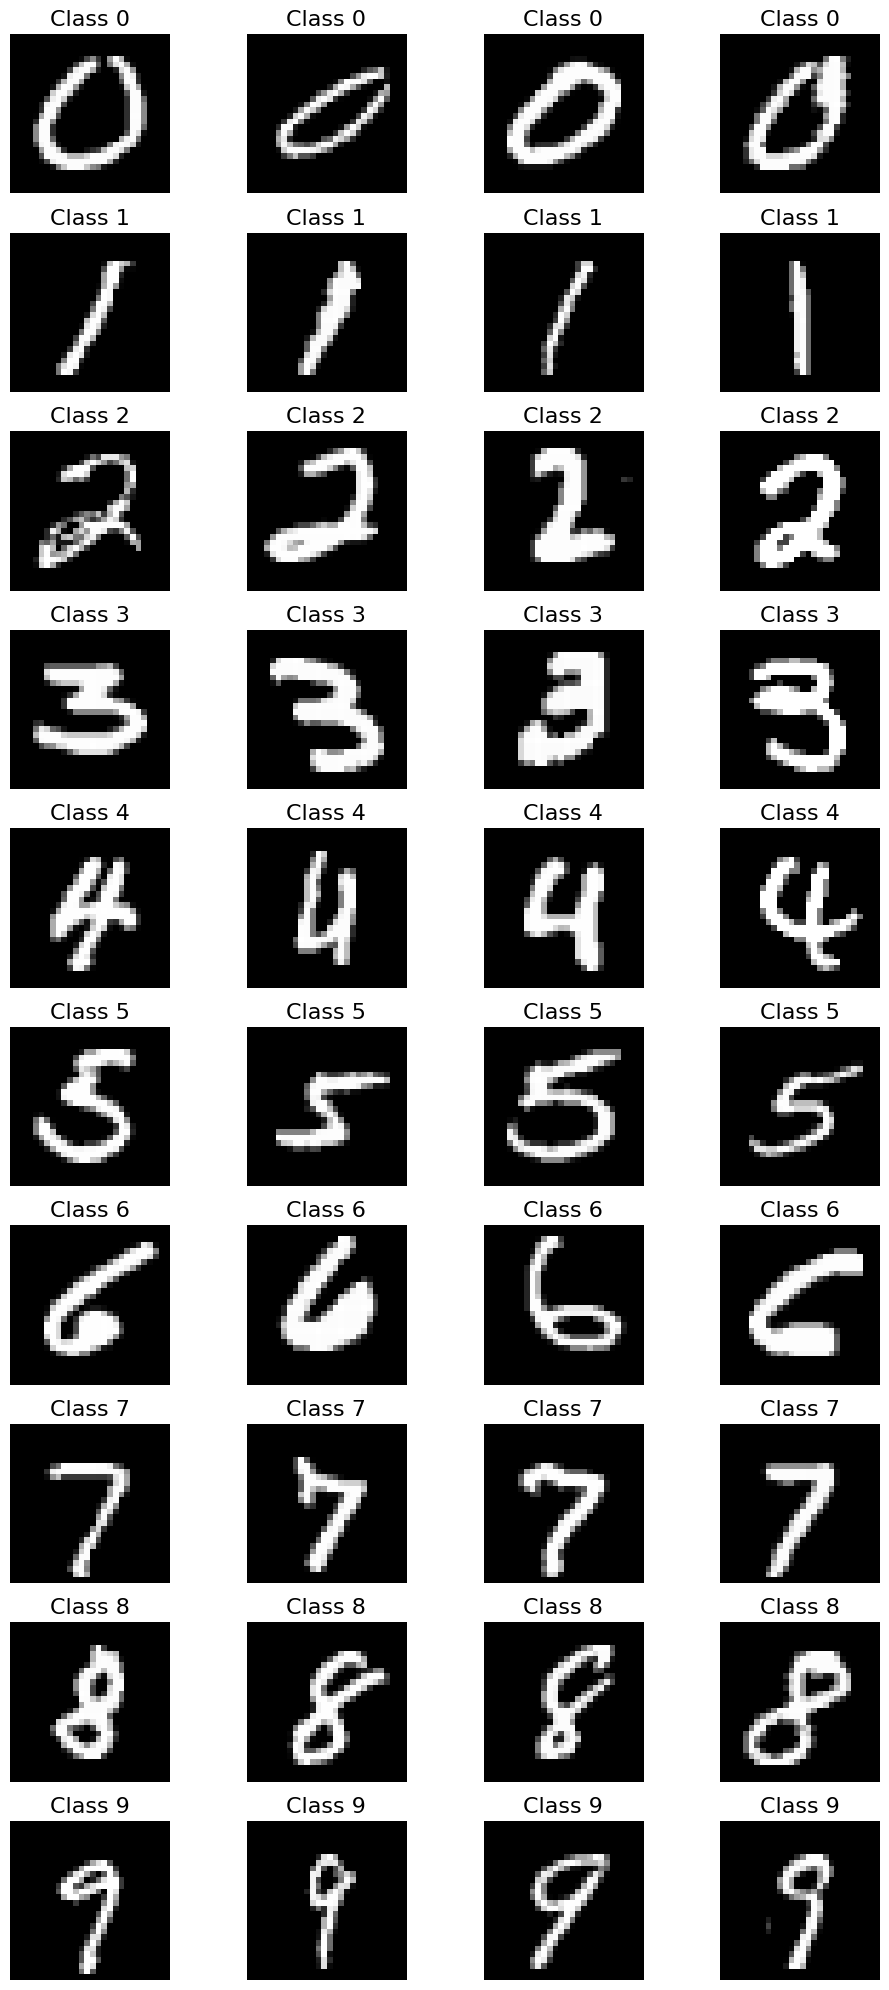

In [4]:
# Use the function to show random images from each class 
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)


    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def encode(self,x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_logvar(a1)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))
  
        

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, 784), reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [18]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    print_per = 100
    loss_record = []
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        train_loss = 0
        print_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Flatten the data and recon tensors
            # TODO: Forward process
            data = data.reshape(-1, 28*28)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            
            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()

            if (epoch == 0):
                loss_record.append(loss.item())
            train_loss += loss.item()
            print_loss += loss.item()
            optimizer.step()
        
        avg_loss = loss.item() / len(data)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decode(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        """# TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = None  # TODO: Save the model

    # TODO: Save the best model to a file
    None
    print("Best model saved as 'best_vae_mlp_model.pth'")"""
    return loss_record



##################################################
VAE-MLP Epoch [1/10], Loss: 168.15447265625
Sample Images:


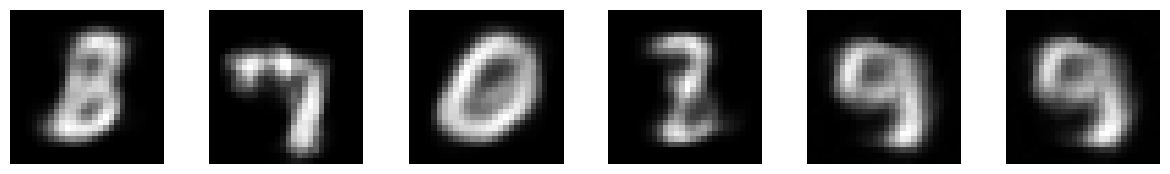


##################################################
VAE-MLP Epoch [2/10], Loss: 155.2716796875
Sample Images:


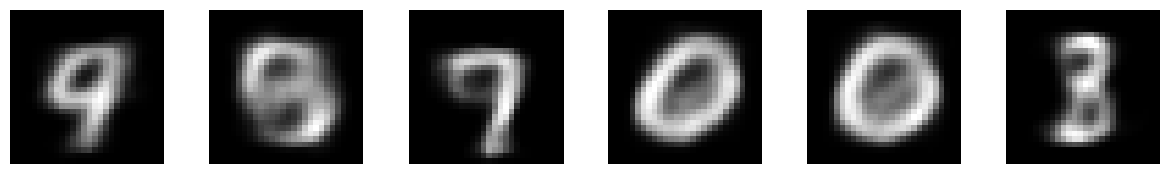


##################################################
VAE-MLP Epoch [3/10], Loss: 157.22373046875
Sample Images:


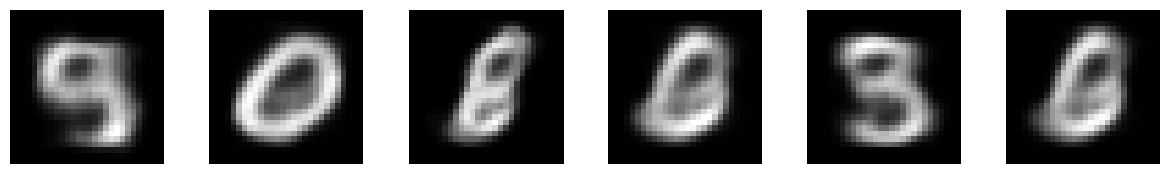


##################################################
VAE-MLP Epoch [4/10], Loss: 157.229453125
Sample Images:


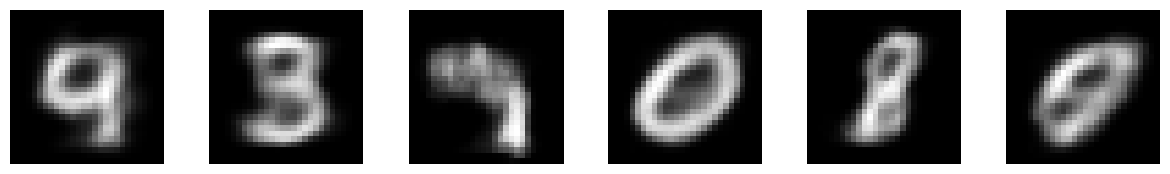


##################################################
VAE-MLP Epoch [5/10], Loss: 158.19619140625
Sample Images:


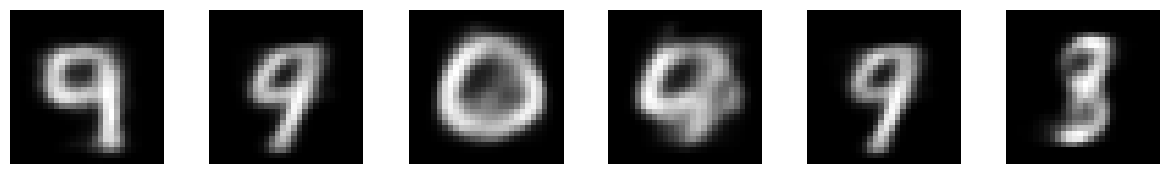


##################################################
VAE-MLP Epoch [6/10], Loss: 153.419609375
Sample Images:


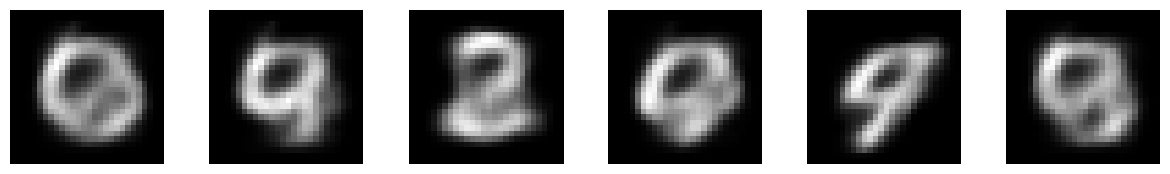


##################################################
VAE-MLP Epoch [7/10], Loss: 145.79025390625
Sample Images:


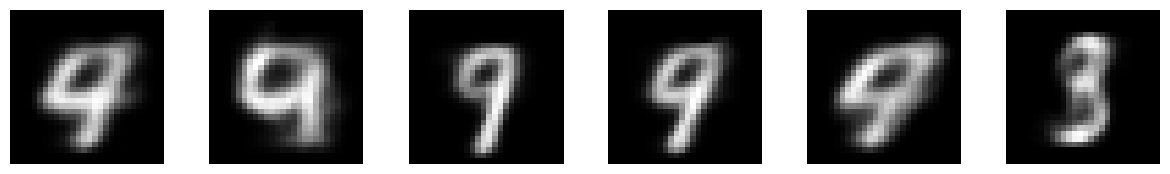


##################################################
VAE-MLP Epoch [8/10], Loss: 150.087470703125
Sample Images:


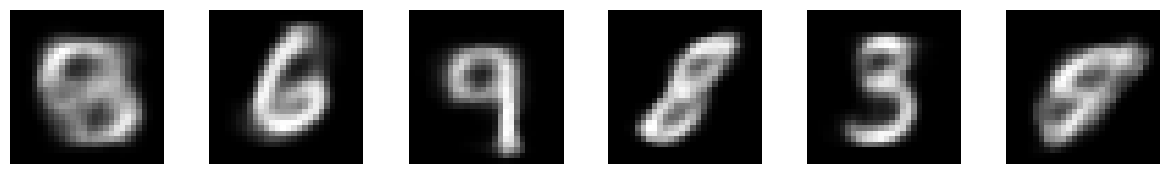


##################################################
VAE-MLP Epoch [9/10], Loss: 153.467529296875
Sample Images:


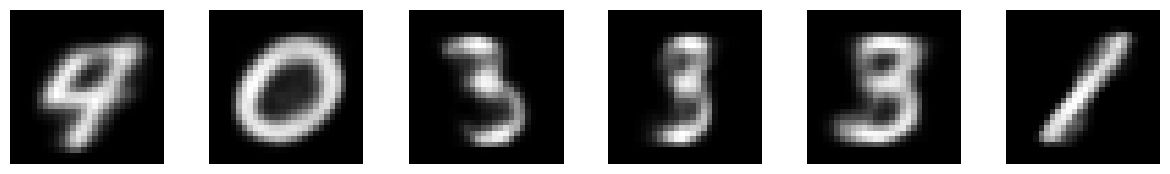


##################################################
VAE-MLP Epoch [10/10], Loss: 157.53548828125
Sample Images:


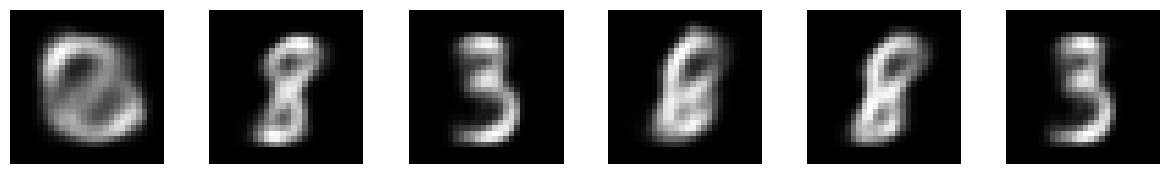

In [19]:
# Train VAE-MLP
input_dim = 784
hidden_dim = 400
latent_dim = 2 
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
loss_record_VAE = train_vae_mlp(vae_mlp, train_loader)

(2000, 2)
torch.Size([2000])


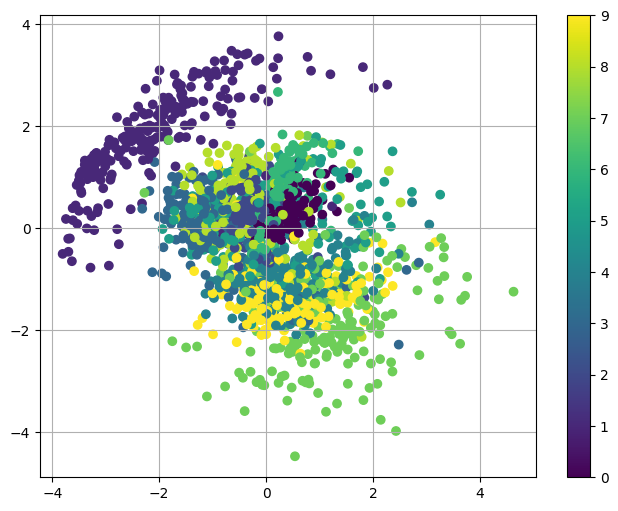

In [20]:
import matplotlib.pyplot as plt
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=2000, shuffle=False)
x_set, y_set = next(iter(test_loader))
x_set = x_set.reshape(-1, 28*28)
z_set = vae_mlp.encode(x_set)[0].detach().numpy()
print(z_set.shape)
print(y_set.shape)
color = y_set
plt.figure(figsize=(8,6))
plt.scatter(z_set[:, 0], z_set[:, 1], c=color, cmap = "viridis")
plt.colorbar()
plt.grid()


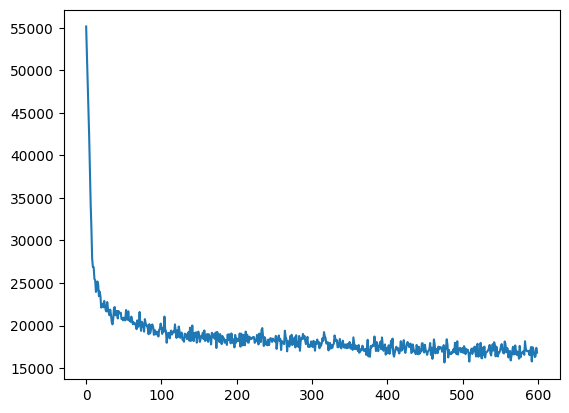

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_record_VAE)

# 2) CVAE --> MLP

In [11]:
# Define a simple CVAE class with MLP architecture
def one_hot(labels, num_classes):
    targets = torch.zeros(labels.size(0), num_classes)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        """self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.latent_dim = latent_dim
        self.num_classes = num_classes"""
        # TODO: Define the architecture of the encoder
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc31 = nn.Linear(hidden_dim2, latent_dim)
        self.fc32 = nn.Linear(hidden_dim2, latent_dim)

        # TODO: Define the architecture of the decoder
        self.fc4 = nn.Linear(latent_dim + num_classes, hidden_dim2)
        self.fc5 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc6 = nn.Linear(hidden_dim1, input_dim)


    def reparameterize(self, mu, logvar):
    # TODO: Implement the reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
    
    def encoder(self,x,c):

        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        a_mu = self.fc31(h)
        a_logvar = self.fc32(h)
        return a_mu, a_logvar

  
    def decoder(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))




    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z, c), mu, log_var


In [12]:
# In this part we need a one_hotter :)
def one_hot(labels, num_classes):
    targets = torch.zeros(labels.size(0), num_classes)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets



# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar):
    # TODO: Flatten the data tensor
    data = data.view(-1, 784)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, 784), reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = None

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence


In [13]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=5, learning_rate=1e-3):
    loss_record = []
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            # One-hot encode the labels
            labels = one_hot(labels, labels_dim)     # one-hot labels
            optimizer.zero_grad() 

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon_batch, mu, log_var = model(data, labels)
            loss = cvae_loss(recon_batch, data, mu, log_var)

            # TODO: Backpropagation and optimization step
            loss.backward()
            if (epoch == 0):
                loss_record.append(loss.item())
            total_loss += loss.item()
            optimizer.step()


        avg_loss = loss.item() / len(data)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(z,y).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        """ # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = None

    # TODO: Save the best model to a file
    None
    print("Best model saved as 'best_cvae_mlp_model.pth'") """
    return loss_record


c:\Users\Sun Media\anaconda3\envs\sa1\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")



##################################################
CVAE-MLP Epoch [1/5], Loss: 140.63025390625
Sample Images:


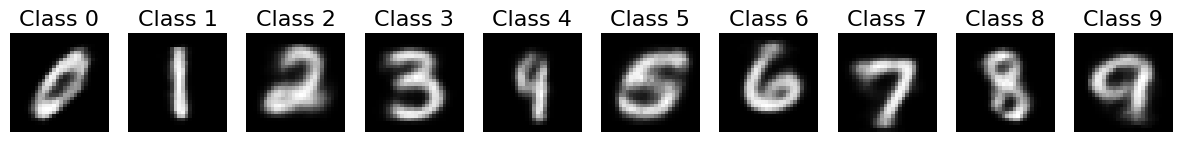


##################################################
CVAE-MLP Epoch [2/5], Loss: 134.925849609375
Sample Images:


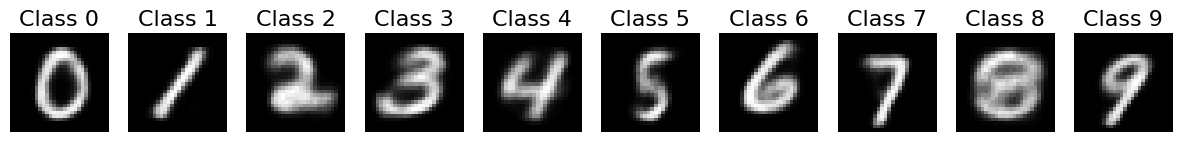


##################################################
CVAE-MLP Epoch [3/5], Loss: 128.123310546875
Sample Images:


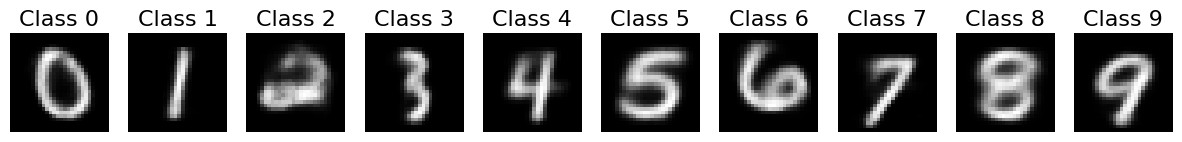


##################################################
CVAE-MLP Epoch [4/5], Loss: 130.595048828125
Sample Images:


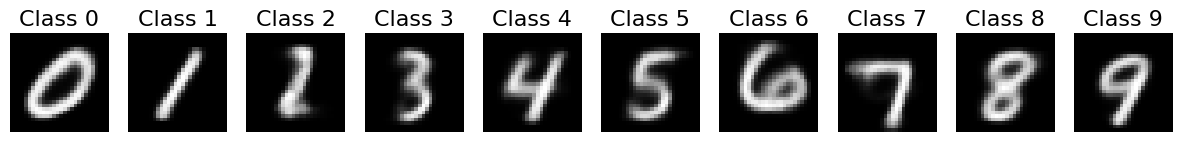


##################################################
CVAE-MLP Epoch [5/5], Loss: 127.510625
Sample Images:


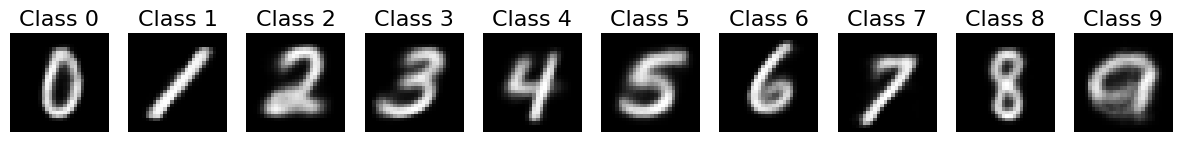

In [14]:
labels_dim = train_loader.dataset.train_labels.unique().size(0)
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim1=512, hidden_dim2 = 256, latent_dim =2, num_classes =labels_dim)
loss_record_cvae = train_cvae_mlp(cvae_mlp, train_loader)

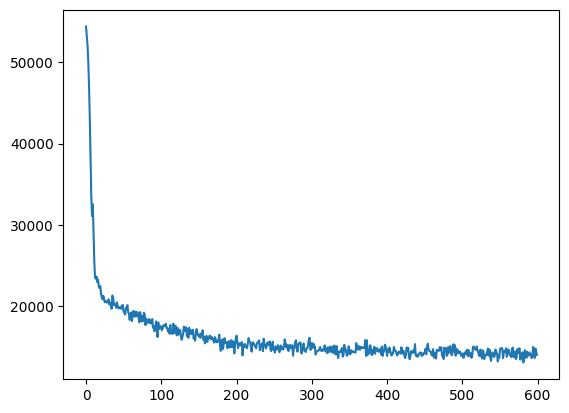

In [15]:
import matplotlib.pyplot as plt
plt.plot(loss_record_cvae)

(2000, 2)
torch.Size([2000])


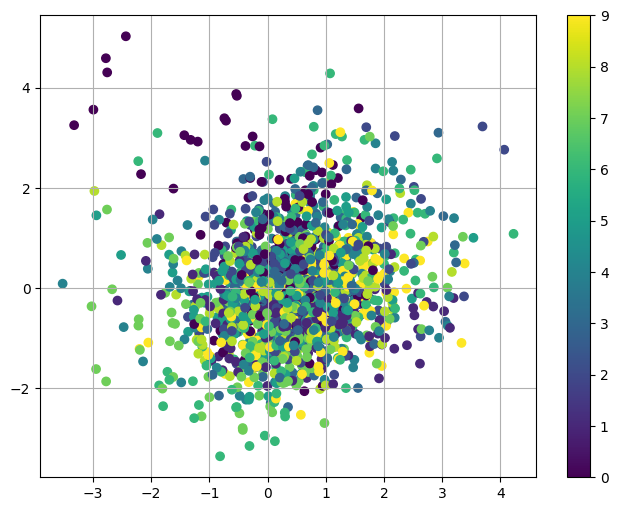

In [16]:
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=2000, shuffle=False)
x_set, y_set = next(iter(test_loader))
x_set = x_set.reshape(-1, 28*28)
y_set_onehot= one_hot(y_set, 10)   
z_set = cvae_mlp.encoder(x_set,y_set_onehot)[0].detach().numpy()
print(z_set.shape)
print(y_set.shape)
color = y_set
plt.figure(figsize=(8,6))
plt.scatter(z_set[:, 0], z_set[:, 1], c=color, cmap = "viridis")
plt.colorbar()
plt.grid()

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


## **Results(latent space representation plots) for part 3: They are displayed in the previous parts for both VAE and CVAE**

* **Difference between VAE and cVAE:**
\ Based on our results which are alligned with theory, difference between a Variational Autoencoder (VAE) and a Conditional Variational Autoencoder (CVAE) lies in their ability to handle conditional generation tasks. Specifically, a VAE is an unsupervised learning model that learns a latent representation of input data, while a CVAE extends the VAE by incorporating conditional information into both the encoding and decoding process. The encoding and decoding process in a VAE is unsupervised, meaning that the model learns to represent the input data without direct reliance on any specific labels or conditional information.On the other hand, in CVAE the encoding and decoding process takes into account conditional information, such as class labels or any other relevant conditioning variables. By incorporating conditional information, a CVAE is capable of generating or reconstructing data conditioned on specific attributes or labels. 
* **Difference in latent space:** 
\
In a conditional VAE, the approximate posterior is already conditioned on the class  q(z|X,c), so there is no need for the latent space to separate the class of each input. In cVAE, it knows how to produce different classes because the decoder is also conditioned on the class. This is alligned with the results.  
